# Chapter 2 - Numerical Example

## Initial Paramaters

In [1]:
using Ipopt, JuMP, LinearAlgebra, PyPlot

#Define parameters:
Q = [1 0; 0 1]
A = [1.2 0.8; 0 1]
b = [1; 0.5]
x_init = [7; 4] # Initial states x (1)
r = 0.4
Kf = 11 # End of the horizon
n = length( x_init ); # Length of vector x

## Omsiscient optimization

In [2]:
# Omniscient optimization :
# Naming the model and specifying the solver
LQR = Model(Ipopt.Optimizer)
set_silent(LQR)

# Defining the decision variables for omniscient optimization
@variable(LQR, u[1:Kf-1] ) # decision variables ( controls )
@variable(LQR, x[1:n, 1: Kf] ) # decision variables ( states )

# Initial conditions :
# Initial value of J_om
J = 0
# Initial State x[1] = x_init
@constraint(LQR, x[:,1] .== x_init )

for k in 1:Kf-1
    # J_om = sum of x[k+1] '*Q*x[k +1] + ru[k]^2
    J += dot(x[:,k+1], Q*x[:,k+1]) + r*u[k]^2
    # dot (x[k+1],Q*x[k +1]) = x[k+1] '*Q*x[k+1] , but returns a scalar instead of an array of 1- element
    # Subject to x(k+1) = Ax(k) + bu(k)
    @constraint(LQR, x[:,k+1] .== A*x[:,k] + b*u[k] )
end

@objective(LQR , Min , J) # Minimize J_om

optimize!(LQR) # Carrying out the omniscient optimization
u_om = JuMP.value.(u)
x_om = JuMP.value.(x)
J_om = JuMP.objective_value(LQR)

# rounding code output to four digits for a clean display
println(" Omniscient controls , u = ", round.(u_om, digits =4) )
println(" Omniscient states , x1 = ", round.(x_om[1 ,:], digits =4) )
println(" Omniscient states , x2 = ", round.(x_om[2 ,:], digits =4) )
println(" Omniscient perf . index , J = ", round.(J_om, digits =4) )


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

 Omniscient controls , u = [-9.3111, -1.4011, 0.4361, 0.6671, 0.5388, 0.3765, 0.2496, 0.1616, 0.1017, 0.0557]
 Omniscient states , x1 = [7.0, 2.2889, 0.8211, 0.3364, 0.1603, 0.0875, 0.0534, 0.0362, 0.0273, 0.0214, 0.009]
 Omniscient states , x2 = [4.0, -0.6556, -1.3561, -1.1381, -0.8046, -0.5352, -0.3469, -0.2221, -0.1413, -0.0905, -0.0626]
 Omniscient perf . index , J = 46.6964


## Costate computation: 

In [3]:
λ = zeros(n, Kf)
check = zeros(Kf) 

AT = transpose(A)
bT = transpose(b)

for k = 1:Kf-1
    #compute the costates: (2.14) 
    λ[:,Kf-k] = (2*AT*Q*A*x_om[:,Kf-k] + 2*AT*Q*b*u_om[Kf-k]
              + AT*λ[:,Kf-k+1])
    
    #check B'λ
    check[Kf-k]  = bT*λ[:,Kf-k]
end

println(" bTλ = ", round.(check, digits =4) )

 bTλ = [13.0825, 3.5267, 0.8349, 0.1164, -0.0496, -0.0709, -0.0612, -0.05, -0.0426, -0.0337, 0.0]


## OSA optimization

In [4]:
# Allocating memory
u_os = zeros(Kf-1)
x = zeros(n,Kf)

# Initial conditions :
# Initial value of J = sum of J_os
J = 0
# Initial State x[1] = x_init
x[:,1] = x_init

for k in 1:Kf-1
    # OSA optimization
    # Naming the model and specifying the solver
    LQR = Model(Ipopt.Optimizer)
    set_silent(LQR)
    @variable(LQR, u) # OSA Control for kth loop
    @variable(LQR, xn[1:n]) # Next state for kth loop

    # J_os = x[k+1] '*Q*x[k+1] + ru[k]^2
    J_os = dot(xn, Q*xn) + r*u^2
    # dot (x[k+1] , Q*x[k +1]) = x[k+1] '*Q*x[k+1] , but returns a scalar instead of an array of 1- element

    # Subject to x(k+1) = Ax(k) + bu(k)
    @constraint(LQR, xn .== A*x[:,k] + b*u)

    @objective(LQR, Min ,J_os) # Minimize J_os

    # Carrying out the OSA optimization
    optimize!(LQR)
    u_os[k] = JuMP.value.(u)
    x[:,k+1] = JuMP.value.(xn)
    # Cumulative performance index
    J += JuMP.objective_value(LQR)
end

# rounding code output to four digits for a clean display
println(" OSAO controls , u = ", round.(u_os , digits =4) )
println(" OSAO states , x1 = ", round.(x[1,:] , digits =4) )
println(" OSAO states , x2 = ", round.(x[2,:] , digits =4) )
println(" OSAO cumulative perf . index , J = ", round(J, digits =4) )

 OSAO controls , u = [-8.2424, -2.3464, -0.1334, 0.5386, 0.6199, 0.512, 0.372, 0.2524, 0.1641, 0.1036]
 OSAO states , x1 = [7.0, 3.3576, 1.5857, 0.7339, 0.3305, 0.143, 0.0581, 0.0211, 0.0059, 0.0002, -0.0015]
 OSAO states , x2 = [4.0, -0.1212, -1.2944, -1.3611, -1.0918, -0.7819, -0.5259, -0.3398, -0.2136, -0.1316, -0.0798]
 OSAO cumulative perf . index , J = 50.1224


## OSA optimization (analytical simulation)

In [5]:
#Allocating memory
u_sim = zeros(Kf-1)
x_sim = zeros(n,Kf)

# Initial conditions: 
# Initial value of J = sum of J_os  
J = 0
# Initial State x[1] = x_init
x_sim[:,1] = x_init

for k = 1:Kf-1
    # u(k) = - (b^T W A x(k))/(b^T W b + r)
    u_sim[k] = - dot(b, Q*A*x_sim[:,k]) / (dot(b, Q*b) + r)
    
    # x(k+1) = Ax(k) + bu(k)
    x_sim[:,k+1] = A*x_sim[:,k] + b*u_sim[k]
    
    #Cumulated performance index (ie., J = sum of J_os)
    # J(k+1) = J(k) + x(k+1)^T Q x(k+1) + ru(k)^2 
    J += dot(x_sim[:,k+1], Q*x_sim[:,k+1]) + r*u_sim[k]^2  
end

# rounding code output to four digits for a clean display
println("Simulated controls, u = ", round.(u_sim, digits =4) )
println("Simulated states, x1 = ", round.(x_sim[1,:], digits =4) )
println("Simulated states, x2 = ", round.(x_sim[2,:], digits =4) )
println("Cumulative perform. index, J = ", round(J, digits =4) )

Simulated controls, u = [-8.2424, -2.3464, -0.1334, 0.5386, 0.6199, 0.512, 0.372, 0.2524, 0.1641, 0.1036]
Simulated states, x1 = [7.0, 3.3576, 1.5857, 0.7339, 0.3305, 0.143, 0.0581, 0.0211, 0.0059, 0.0002, -0.0015]
Simulated states, x2 = [4.0, -0.1212, -1.2944, -1.3611, -1.0918, -0.7819, -0.5259, -0.3398, -0.2136, -0.1316, -0.0798]
Cumulative perform. index, J = 50.1224


## Comparison Plots:

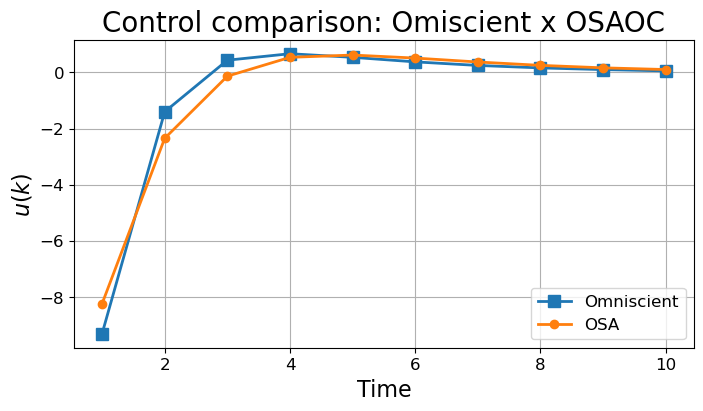

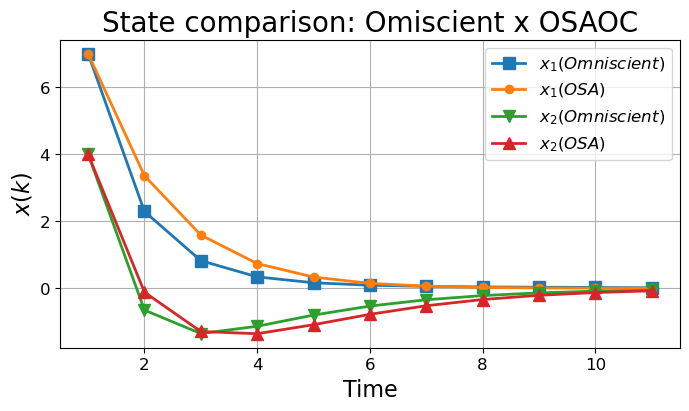

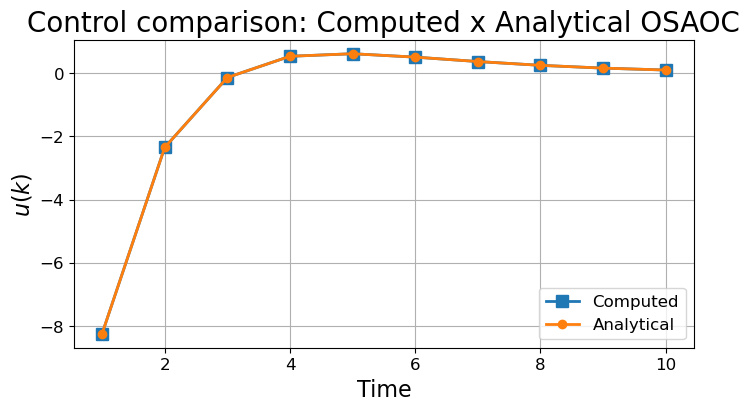

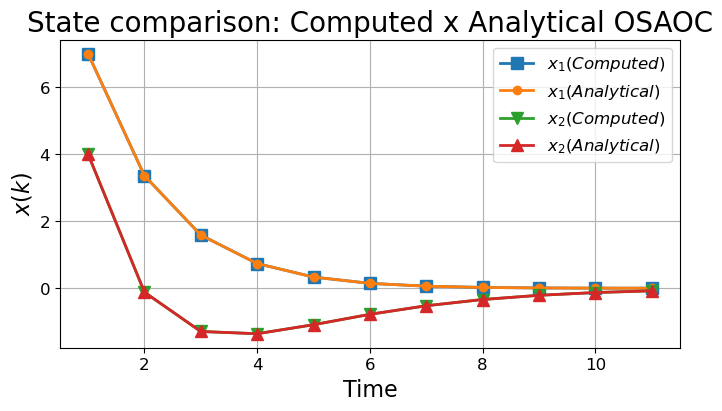

In [6]:
PyPlot.svg(true)

t1 = Array(1:1:Kf)
t2 = Array(1:1:Kf-1)

save_files = false #true - save all figures and data / false - do not save

figure(figsize=(8,4))
title("Control comparison: Omiscient x OSAOC",fontsize=20)
plot(t2, u_om,"s-",linewidth=2,markersize=8 )
plot(t2, u_os,"o-",linewidth=2,markersize=6 )
xlabel("Time",fontsize=16)
ylabel("\$u(k)\$",fontsize=16)
legend(["Omniscient", "OSA"],loc="best",fontsize=12)
xticks(fontsize=12)
yticks(fontsize=12)
grid()
if save_files
    savefig("control_comp_osa_omni.eps", bbox_inches="tight")
end

figure(figsize=(8,4))
title("State comparison: Omiscient x OSAOC",fontsize=20)
plot(t1, x_om[1,:],"s-",linewidth=2,markersize=8 )
plot(t1, x[1,:],"o-",linewidth=2,markersize=6 )
plot(t1, x_om[2,:],"v-",linewidth=2,markersize=8 )
plot(t1, x[2,:],"^-",linewidth=2,markersize=8 )
xlabel("Time",fontsize=16)
ylabel("\$x(k)\$",fontsize=16)
legend([L"x_1 (Omniscient)", L"x_1 (OSA)",L"x_2 (Omniscient)", L"x_2 (OSA)"],loc="best",fontsize=12)
xticks(fontsize=12)
yticks(fontsize=12)
grid()
if save_files
    savefig("state_comp_osa_omni.eps", bbox_inches="tight")
end

figure(figsize=(8,4))
title("Control comparison: Computed x Analytical OSAOC",fontsize=20)
plot(t2, u_os,"s-",linewidth=2,markersize=8 )
plot(t2, u_sim,"o-",linewidth=2,markersize=6 )
xlabel("Time",fontsize=16)
ylabel("\$u(k)\$",fontsize=16)
legend(["Computed", "Analytical"],loc="best",fontsize=12)
xticks(fontsize=12)
yticks(fontsize=12)
grid()
if save_files
    savefig("control_comp_osa_sim.eps", bbox_inches="tight")
end

figure(figsize=(8,4))
title("State comparison: Computed x Analytical OSAOC",fontsize=20)
plot(t1, x[1,:],"s-",linewidth=2,markersize=8 )
plot(t1, x_sim[1,:],"o-",linewidth=2,markersize=6 )
plot(t1, x[2,:],"v-",linewidth=2,markersize=8 )
plot(t1, x_sim[2,:],"^-",linewidth=2,markersize=8 )
xlabel("Time",fontsize=16)
ylabel("\$x(k)\$",fontsize=16)
legend([L"x_1 (Computed)", L"x_1 (Analytical)",L"x_2 (Computed)", L"x_2 (Analytical)"],loc="best",fontsize=12)
xticks(fontsize=12)
yticks(fontsize=12)
grid()
if save_files
    savefig("state_comp_osa_sim.eps", bbox_inches="tight")
end